In [9]:
import pandas as pd
import numpy as np
import json  # Para parsear .geo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

In [2]:
# Definir rangos de años
years = range(2000, 2025)  # De 2000 a 2024 inclusive

# Listas para acumular dataframes procesados
modis_list = []
no_incendios_list = []

# Loop para cargar y procesar modis (incendios positivos)
for year in years:
    modis_file = f'Incendios/modis_{year}_Peru.csv'
    if os.path.exists(modis_file):
        modis_df_year = pd.read_csv(modis_file)

        # Filtrar a región de San Martín (ajusta rangos si necesitas precisión)
        san_martin_modis_year = modis_df_year[
            (modis_df_year['latitude'] >= -7.5) & (modis_df_year['latitude'] <= -5.5) &
            (modis_df_year['longitude'] >= -77.5) & (modis_df_year['longitude'] <= -75.5)
        ].copy() # <-- .copy() evita el warning

        # Agregar label
        san_martin_modis_year['incendio'] = 1

        # Seleccionar columnas relevantes
        san_martin_modis_year = san_martin_modis_year[['acq_date', 'latitude', 'longitude', 'incendio']]

        modis_list.append(san_martin_modis_year)
        # print(f"Cargado y filtrado modis_{year}: {len(san_martin_modis_year)} registros")
    else:
        print(f"Archivo no encontrado: {modis_file}")

# Loop para cargar y procesar no_incendios (negativos)
for year in years:
    no_incendios_file = f'NoIncendios/puntos_sin_incendio_sanmartin_{year}.csv'
    if os.path.exists(no_incendios_file):
        no_incendios_df_year = pd.read_csv(no_incendios_file)

        # Parsear .geo para extraer lon y lat
        no_incendios_df_year['longitude'] = no_incendios_df_year['.geo'].apply(lambda x: json.loads(x)['coordinates'][0])
        no_incendios_df_year['latitude'] = no_incendios_df_year['.geo'].apply(lambda x: json.loads(x)['coordinates'][1])

        # Filtrar a región de San Martín
        no_incendios_df_year = no_incendios_df_year[
            (no_incendios_df_year['latitude'] >= -7.5) &
            (no_incendios_df_year['latitude'] <= -5.5) &
            (no_incendios_df_year['longitude'] >= -77.5) &
            (no_incendios_df_year['longitude'] <= -75.5)
        ]

        # Agregar label
        no_incendios_df_year['incendio'] = 0

        # Seleccionar columnas relevantes
        no_incendios_df_year = no_incendios_df_year[['acq_date', 'latitude', 'longitude', 'incendio']]

        no_incendios_list.append(no_incendios_df_year)
        # print(f"Cargado no_incendios_{year}: {len(no_incendios_df_year)} registros")
    else:
        print(f"Archivo no encontrado: {no_incendios_file}")

# Combinar todos los dataframes
all_modis = pd.concat(modis_list, ignore_index=True) if modis_list else pd.DataFrame()
all_no_incendios = pd.concat(no_incendios_list, ignore_index=True) if no_incendios_list else pd.DataFrame()
full_df = pd.concat([all_modis, all_no_incendios], ignore_index=True)

# Ver totales
print(f"Total incendios: {len(all_modis)}")
print(f"Total no incendios: {len(all_no_incendios)}")
print(f"Dataset completo: {len(full_df)}")
full_df.head()

Total incendios: 59018
Total no incendios: 37143
Dataset completo: 96161


,acq_date,latitude,longitude,incendio
0,2000-11-04,-5.8207,-77.3019,1
1,2000-11-05,-5.9875,-76.8958,1
2,2000-11-05,-5.9775,-76.9008,1
3,2000-11-05,-6.4761,-77.4836,1
4,2000-11-05,-6.4902,-77.4817,1


In [3]:
# Convertir acq_date a datetime (maneja errores si hay formatos inconsistentes)
full_df['acq_date'] = pd.to_datetime(full_df['acq_date'], errors='coerce')

# Eliminar rows con fechas inválidas (si hay NaT)
full_df = full_df.dropna(subset=['acq_date'])

# Extraer features temporales
full_df['year'] = full_df['acq_date'].dt.year
full_df['month'] = full_df['acq_date'].dt.month
full_df['day'] = full_df['acq_date'].dt.day
full_df['day_of_year'] = full_df['acq_date'].dt.dayofyear

# Verificar las nuevas columnas
full_df.head()

,acq_date,latitude,longitude,incendio,year,month,day,day_of_year
0,2000-11-04,-5.8207,-77.3019,1,2000,11,4,309
1,2000-11-05,-5.9875,-76.8958,1,2000,11,5,310
2,2000-11-05,-5.9775,-76.9008,1,2000,11,5,310
3,2000-11-05,-6.4761,-77.4836,1,2000,11,5,310
4,2000-11-05,-6.4902,-77.4817,1,2000,11,5,310


In [4]:
features = ['latitude', 'longitude', 'month', 'day', 'day_of_year', 'year']
X = full_df[features]
y = full_df['incendio']

# Ver balance de clases
print(y.value_counts())

incendio
1    59018
0    37143
Name: count, dtype: int64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# 1. Crear el escalador
scaler = StandardScaler()

# 2. Ajustarlo (fit) SOLO con los datos de entrenamiento
scaler.fit(X_train)

# 3. Transformar ambos conjuntos (entrenamiento y prueba)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# (Opcional) Convertir de nuevo a DataFrame para verlos
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)

print("Datos de entrenamiento escalados (ejemplo):")
print(X_train_scaled_df.head())

Datos de entrenamiento escalados (ejemplo):
   latitude  longitude     month       day  day_of_year      year
0  1.696284   0.223322  1.648552 -0.674811     1.574699 -0.459823
1 -0.452825  -0.254843  0.248752 -0.335969     0.208955  1.000994
2 -1.394270  -0.267397  0.248752  0.228768     0.277816 -0.605904
3  0.411479   1.275456  0.598702  0.793505     0.679505  0.416667
4 -1.520388   0.515819  0.948652 -0.223021     0.931996 -0.021578


In [7]:
# Crear modelo
# Usamos class_weight='balanced' para manejar el desbalance de clases
model = LogisticRegression(
    random_state=42,
    class_weight='balanced',  # <-- ¡CAMBIO CLAVE!
    max_iter=1000             # Aumentamos iteraciones para asegurar convergencia
)

# Entrenar el modelo con los datos ESCALADOS
model.fit(X_train_scaled, y_train)

print("Modelo de Regresión Logística entrenado.")

# Predecir en test (también con datos escalados)
y_pred = model.predict(X_test_scaled)

Modelo de Regresión Logística entrenado.


Accuracy: 0.6296469609525295

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.52      0.59      0.55      7429
           1       0.72      0.65      0.68     11804

    accuracy                           0.63     19233
   macro avg       0.62      0.62      0.62     19233
weighted avg       0.64      0.63      0.63     19233


--- Matriz de Confusión ---


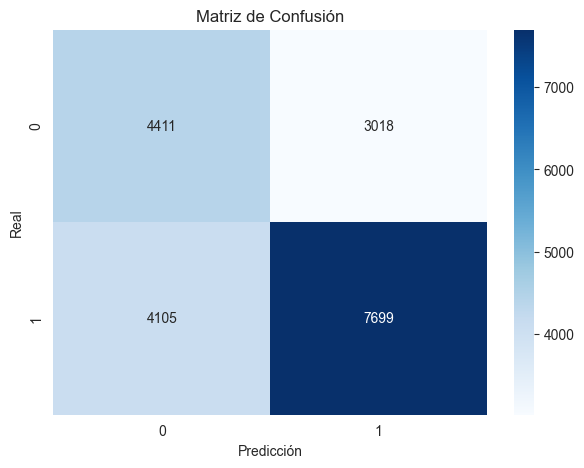


AUC Score: 0.6551
--- Curva ROC ---


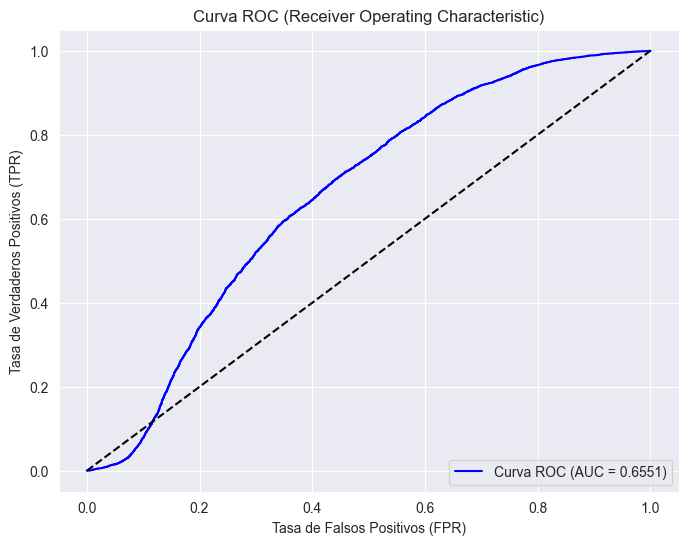


--- Importancia de Features (Coeficientes) ---
             Coefficient
day_of_year     8.370338
longitude       0.074866
year            0.030517
latitude       -0.314587
day            -0.794635
month          -7.932567


C:\Users\User\AppData\Local\Temp\ipykernel_13208\4212603190.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients['Coefficient'], y=coefficients.index, palette='vlag')


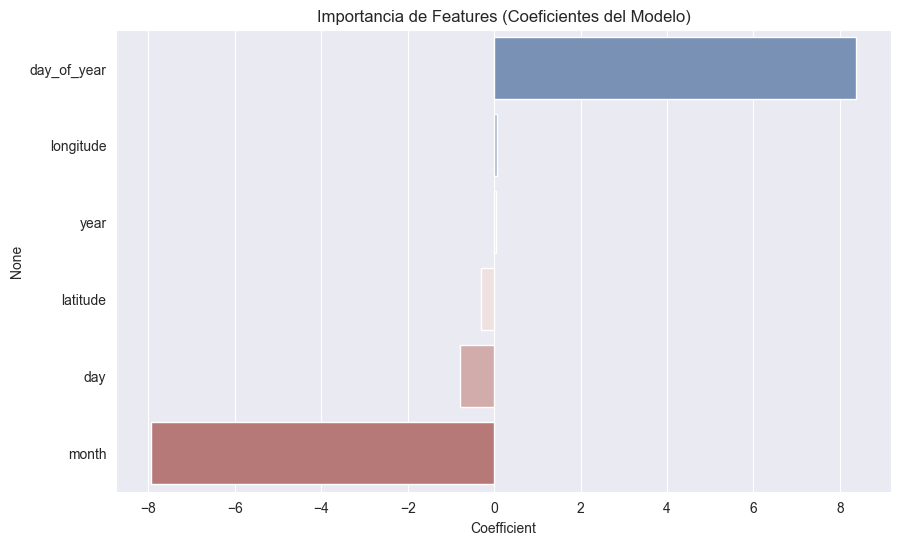

In [10]:
# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC y Puntaje AUC

# 1. Obtener las probabilidades de predicción para la clase positiva (incendio=1)
# ¡¡IMPORTANTE: Usamos X_test_scaled porque el modelo se entrenó con datos escalados!!
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 2. Calcular el puntaje AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_proba)
print(f'\nAUC Score: {auc:.4f}')

# 3. Calcular FPR (Tasa de Falsos Positivos) y TPR (Tasa de Verdaderos Positivos)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 4. Graficar la curva ROC
print("--- Curva ROC ---")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--') # Línea de referencia (azar)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Interpretación de Features (Reemplazo de plot_importance) ---
print("\n--- Importancia de Features (Coeficientes) ---")
coefficients = pd.DataFrame(model.coef_[0], index=features, columns=['Coefficient'])
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print(coefficients)

# Gráfico de coeficientes
plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients['Coefficient'], y=coefficients.index, palette='vlag')
plt.title('Importancia de Features (Coeficientes del Modelo)')
plt.show()

In [ ]:
# Guardar el modelo
joblib.dump(model, 'logistic_regression_incendios_model.joblib')

# ¡CRÍTICO! Guardar también el escalador
joblib.dump(scaler, 'scaler_incendios.joblib')

print("Modelo de Regresión Logística y Scaler guardados.")